In [1]:
import sys
import torch
import time, os
import numpy as np

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from pemp import PEMP


torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

Device : cuda:0


In [2]:
dx, dy, dg, dpe = 1, 1, 1, 10
num_demos, num_val = 3, 1
t_steps = 200
n_max, m_max = 10, 10
num_peaks_max = dg

x = torch.linspace(0, 1, t_steps).view(-1, 1)

# def generate_trajectory(x, peak_x, noise_level=0.0005):
#     y = torch.zeros_like(x)
#     peak_width = 0.1
#     peak_height = 0.2

#     y += peak_height * torch.exp(-((x - peak_x)**2) / (2 * peak_width**2))
#     y += noise_level * torch.randn_like(x)
#     return y


# def with_peaks(num_demos, num_val, num_peaks=1, t_steps=200, interp=True):
#     peak_positions = np.random.rand(num_demos + num_val, num_peaks)

#     y_train = torch.zeros(num_demos, t_steps, 1)
#     y_val = torch.zeros(num_val, t_steps, 1)

#     if interp:
#         # interp_pp = np.sort(peak_positions)[1:-1]
#         val_peaks = np.random.choice(np.squeeze(np.sort(peak_positions)[1:-1], axis=-1), num_val, replace=False)
#         train_peaks = np.array([x for x in np.sort(peak_positions) if x not in val_peaks])

#     else:
#         train_peaks = np.sort(peak_positions)[:num_demos]
#         val_peaks = np.sort(peak_positions)[num_demos:]

#     for i, peak in enumerate(train_peaks):
#         x = torch.linspace(0, 1, t_steps)
#         y_train[i] = generate_trajectory(x, peak)
    
#     for i, peak in enumerate(val_peaks):
#         x = torch.linspace(0, 1, t_steps)
#         y_val[i] = generate_trajectory(x, peak)
    
#     return y_train, y_val

train_data = []
val_data = []

# for i in range(num_demos):
#     num_peaks = dg #np.random.choice([1, 2, 4])  # Randomly choose 1, 2, or 4 dg
#     y, peak_positions = with_peaks(x, num_peaks)
#     train_data.append((y, peak_positions))

# for i in range(num_val):
#     y, peak_positions = generate_trajectory_with_peaks(x, dg) # Always generate 3 peaks for validation
#     val_data.append((y, peak_positions))

y_train, y_val = with_peaks(num_demos, num_val, num_peaks=dg)

# y_train = torch.stack([y for y, _ in train_data], dim=0)
# y_val = torch.stack([y for y, _ in val_data], dim=0)

# y_train = torch.zeros(num_demos, t_steps, dy)
# y_val = torch.zeros(num_val, t_steps, dy)
# gamma_train = torch.zeros(num_demos, num_peaks_max)
# gamma_val = torch.zeros(num_val, num_peaks_max)

# for i, data in enumerate(train_data):
#     y, peak_positions = data
#     y_train[i, :, :] = y
#     # for ppid, pp in enumerate(peak_positions):
#     #     gamma_train[i, ppid] = pp

# for i, data in enumerate(val_data):
#     y, peak_positions = data
#     y_val[i, :, :] = y
#     # for ppid, pp in enumerate(peak_positions):
#     #     gamma_val[i, ppid] = pp

x_train = x.unsqueeze(0).repeat(num_demos, 1, 1)
x_val = x.unsqueeze(0).repeat(num_val, 1, 1)

# y_val = y_train

# Print shapes
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")

RuntimeError: The expanded size of the tensor (1) must match the existing size (200) at non-singleton dimension 1.  Target sizes: [200, 1].  Tensor sizes: [200]

NameError: name 'x_train' is not defined

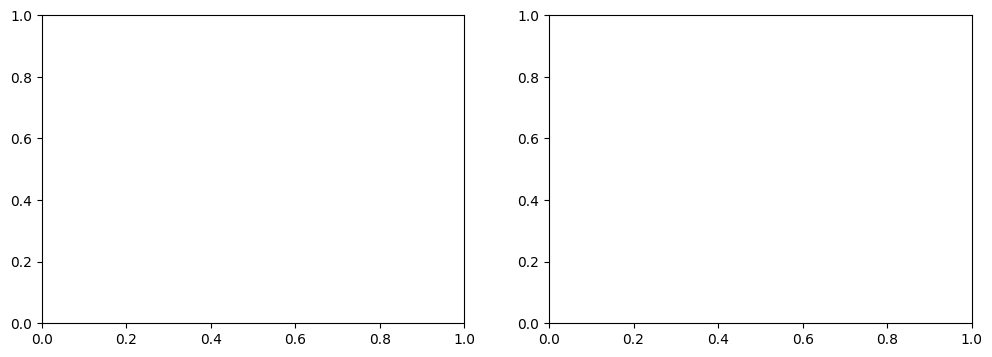

In [3]:
import matplotlib.pyplot as plt
# plot train trajectories on the left and validation trajectories on the right
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i in range(num_demos):
    axs[0].plot(x_train[i, :, 0], y_train[i, :, 0], label=f"Demo {i}")
for i in range(num_val):
    axs[0].plot(x_val[i, :, 0], y_val[i, :, 0], label=f"Val {i}", color='black', linestyle='dashed')
    axs[1].plot(x_val[i, :, 0], y_val[i, :, 0], label=f"Val {i}", color='black', linestyle='dashed')
axs[0].set_title("Training")
axs[1].set_title("Validation")
axs[0].grid(True)
axs[1].grid(True)
plt.show()

In [32]:
batch_size = 1

model = PEMP(input_dim=dpe+dg, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=[128, 128, 128], decoder_hidden_dims=[128, 128, 128], batch_size=batch_size, device=device)
optimizer = torch.optim.Adam(lr=3e-4, params=model.parameters())

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)


if torch.__version__ >= "2.0":
    model_ = torch.compile(model)
else:
    model_ = model

69378


100%|██████████| 10/10 [00:00<00:00, 312.32it/s]


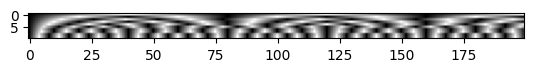

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0250, 0.0500, 0.0750,  ..., 0.2000, 0.2250, 0.2500],
        [0.0500, 0.1000, 0.1500,  ..., 0.4000, 0.4500, 0.5000],
        ...,
        [0.9250, 0.1500, 0.8250,  ..., 0.6000, 0.6750, 0.7500],
        [0.9500, 0.1000, 0.7500,  ..., 0.4000, 0.4500, 0.5000],
        [0.9750, 0.0500, 0.6750,  ..., 0.2000, 0.2250, 0.2500]])


In [33]:
import math
from tqdm import tqdm

def generate_positional_encoding(length=t_steps, d_model=4):  # d_model: dimension of encoding space
    pos = torch.arange(length).unsqueeze(1)  # (length, 1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))  # (d_model/2,)
    pe = torch.zeros(length, d_model)  # (length, d_model)
    pe[:, 0::2] = torch.sin(pos * div_term)
    pe[:, 1::2] = torch.cos(pos * div_term)
    return pe


def generate_encoding(len=200, d_model=4):
    enc = torch.zeros(d_model, len)
    max_num = len

    i, j = 0, 1

    for i in tqdm(range(d_model)):
        increment = (i + 1) * 5
        
        while True:
            while enc[i, j-1] <= max_num-increment and j < len:
                enc[i, j] = enc[i, j-1] + increment
                j += 1
            while enc[i, j-1] >= increment and j < len:
                enc[i, j] = enc[i, j-1] - increment
                j += 1

            if j < len:
                continue
            else:
                j = 1
                break
    return enc.T  

d_model = 10
pe = generate_encoding(d_model=d_model) / t_steps

# for i in range(t_steps):
#     for j in range(d_model):
#         print(pe[i, j].item(), end='\t')
#     print()

    # pe = torch.zeros((4, 200))
    # for i in range(4):
    #     pe[i] = torch.linspace(0, 1, t_steps)
    # return pe.T


# pe = generate_positional_encoding(1000, 256)

import matplotlib.pyplot as plt
plt.imshow(pe.T, cmap=plt.get_cmap('gray'))
plt.show()

print(pe)

In [34]:
dpe_aug = dpe + dg  # dg for gamma (peak_positions)

obs = torch.zeros((batch_size, n_max, dpe_aug+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dpe_aug), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]
        pe = generate_positional_encoding(traj.shape[0], dpe) / dpe
        gamma = torch.zeros(dg)

        for ppid, pp in enumerate(gamma_train[traj_id]):
            gamma[ppid] = pp  # gamma: peak_positions

        n = torch.randint(5, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        obs[i, :n, :dpe] = pe[n_ids] # PE(t)
        obs[i, :n, dpe:dpe_aug] = gamma
        obs[i, :n, dpe_aug:] = traj[n_ids]  # SM(t)
        obs_mask[i, :n] = True
        
        tar_x[i, :m, :dpe] = pe[m_ids]
        tar_x[i, :m, dpe:] = gamma
        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True

val_obs = torch.zeros((batch_size, n_max, dpe_aug+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dpe_aug), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(t: list, traj_ids: list):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]
        pe = generate_positional_encoding(traj.shape[0], dpe) / dpe
        gamma = torch.zeros(dg)
        
        for ppid, pp in enumerate(gamma_val[traj_id]):
            gamma[ppid] = pp  # gamma: peak_positions

        n = torch.randint(5, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        
        val_obs[i, :n, :dpe] = pe[n_ids]
        val_obs[i, :n, dpe:dpe_aug] = gamma
        val_obs[i, :n, dpe_aug:] = traj[n_ids]
        val_obs_mask[i, :n] = True
        
        val_tar_x[i, :, :dpe] = pe
        val_tar_x[i, :, dpe:] = gamma
        val_tar_y[i] = traj[m_ids]

In [35]:
import time
import os

timestamp = int(time.time())
root_folder = f'../outputs/tests/simple/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

img_folder = f'{root_folder}img/'
if not os.path.exists(img_folder):
    os.makedirs(img_folder)

torch.save(y_train, f'{root_folder}y.pt')

epochs = 2000000
epoch_iter = num_demos // batch_size
v_epoch_iter = num_val//batch_size
avg_loss = 0
val_per_epoch = 1000
min_val_loss = 1000000
mse_loss = torch.nn.MSELoss()

plot_validation = True


for epoch in range(epochs):
    epoch_loss = 0

    traj_ids = torch.randperm(num_demos)[:batch_size * epoch_iter].chunk(epoch_iter)

    for i in range(epoch_iter):
        prepare_masked_batch(y_train, traj_ids[i])

        optimizer.zero_grad()
        
        pred = model(obs, tar_x, obs_mask)
        loss = model.loss(pred, tar_y, tar_mask)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % val_per_epoch == 0 and epoch > 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(num_val)[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss = 0

            for j in range(v_epoch_iter):
                prepare_masked_val_batch(y_val, v_traj_ids[j])
                pred = model.val(val_obs, val_tar_x, val_obs_mask)
                if plot_validation:
                    for k in range(batch_size):
                        plt.plot(val_tar_y[k, :, 0].cpu().numpy(), label=f"True {k}")
                        plt.plot(pred[k, :, 0].cpu().numpy(), label=f"Pred {k}")
                        
                        plt.legend()
                        plt.savefig(f'{img_folder}val_{epoch}_{j}_{k}.png')
                        plt.clf()
                val_loss += mse_loss(pred[:, :, :model.output_dim], val_tar_y).item()
                
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                print(f'New best: {min_val_loss}')
                torch.save(model_.state_dict(), f'{root_folder}saved_models/pemp.pt')

    avg_loss += epoch_loss

    if epoch % 100 == 0:
        print("Epoch: {}, Loss: {}".format(epoch, avg_loss / 100))
        avg_loss = 0

Epoch: 0, Loss: 0.018546029925346375
Epoch: 100, Loss: -4.154581399746239
Epoch: 200, Loss: -5.866215574741363
Epoch: 300, Loss: -6.131628822088242
Epoch: 400, Loss: -6.217544428408146
Epoch: 500, Loss: -6.586471844911575
Epoch: 600, Loss: -6.433518027067184
Epoch: 700, Loss: -6.577166272550821
Epoch: 800, Loss: -6.8188392400741575
Epoch: 900, Loss: -6.837025869488716
New best: 0.0005123100127093494
Epoch: 1000, Loss: -7.027147132158279
Epoch: 1100, Loss: -7.010691081881523
Epoch: 1200, Loss: -7.118570015430451
Epoch: 1300, Loss: -6.8856641697883605
Epoch: 1400, Loss: -6.981454734802246
Epoch: 1500, Loss: -7.13138039290905
Epoch: 1600, Loss: -7.200977095961571
Epoch: 1700, Loss: -7.383761692047119
Epoch: 1800, Loss: -7.3997855269908905
Epoch: 1900, Loss: -7.641314807534218
New best: 0.00047320727026090026
Epoch: 2000, Loss: -7.709476565122604
Epoch: 2100, Loss: -7.967921464443207
Epoch: 2200, Loss: -8.256255739666521
Epoch: 2300, Loss: -8.719236137866973
Epoch: 2400, Loss: -8.471223548

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>